### t-SNE Results of Seven Types Ligand-Binding Proteins

Ligand Types Used in this Example: ADP, FAD, HEM, NAD, NAP, COA, SAM

In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pandas as pd
import numpy as np
import torch

from sklearn.manifold import TSNE
from model.utils import Net_embed_MLP

In [2]:
# Define ligand types
ligand_types = ["ADP", "FAD", "HEM", "NAD", "NAP", "COA", "SAM"]
# Define colors for each type of ligand-binding pocket
colors = [    
    "#1F77B4",  # ADP: Blue
    "#FF7F0E",  # FAD: Orange
    "#2CA02C",  # HEM: Green
    "#D62728",  # NAD: Red
    "#9467BD",  # NAP: Purple
    "#8C564B",  # COA: Brown
    "#E377C2",  # SAM: Pink
    ]
# t-SNE Model
tsne = TSNE(n_components=2, perplexity=25, learning_rate='auto')
# t-SNE Legend Setting
custom_lines = [Line2D([0], [0], marker='o', markersize=6, color=colors[ligand_types.index(l)], lw=0, linewidth=1) for l in ligand_types]
legend_names = [ligand for ligand in ligand_types]

#### Step 1: Load Dataset

In [3]:
dataset_path = "./Example-Dataset/7types_Test_4183.csv"

pocket_dataset = pd.read_csv(dataset_path)
# Load Pockets' names and ESM-2 Representations
poc_name_list = pocket_dataset["pdb_id"].tolist()
esm2_list = np.asarray([np.asarray(mol[1:-1].split(","), dtype=np.float16) for mol in pocket_dataset["esm2-1280"].to_list()])

print("ESM-2 Data Shape: ", esm2_list.shape, "; Pocket Name List Length: ", len(poc_name_list))

print("Pocket Name Format: (PDB ID)_(Ligand Name)_(OtherInfo)")
print("Example: ", poc_name_list[0])

ESM-2 Data Shape:  (4183, 1280) ; Pocket Name List Length:  4183
Pocket Name Format: (PDB ID)_(Ligand Name)_(OtherInfo)
Example:  155c_HEM_A_1_BS01_LIG_A


In [4]:
# Get pockets' labels
pocket_labels = []
for name in poc_name_list:
    pdb = name.split('_')[1]
    pocket_labels.append(ligand_types.index(pdb))

print("Label List Length: ", len(pocket_labels))

Label List Length:  4183


Before ErePOC: t-SNE Result of ESM-2 Repr.

ESM-2 t-SNE Shape:  (4183, 2)


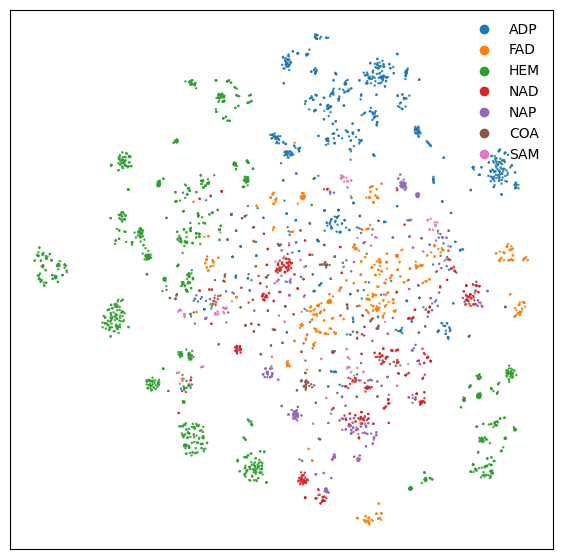

In [5]:
# Get ESM-2 Repr's t-SNE result
esm2_tsne = tsne.fit_transform(esm2_list)
print("ESM-2 t-SNE Shape: ", esm2_tsne.shape)

dot_size, dot_alpha, dot_linewidths = 3, 0.9, 0
plt.figure(figsize=(7,7))
plt.scatter(esm2_tsne[:, 0], esm2_tsne[:, 1], c=[colors[i] for i in pocket_labels[:]], s=dot_size, alpha=dot_alpha, linewidths=dot_linewidths)
plt.legend(custom_lines, legend_names, loc='upper right', bbox_to_anchor=(1.0, 1.0), frameon=False, fontsize=10)
plt.xticks([]); plt.yticks([])
plt.show()

#### Step2: Get ErePOC Representations

In [6]:
esm2_array = torch.from_numpy(esm2_list).float()
print("ESM-2 Data Shape: ", esm2_array.shape)

# Load ErePOC Model
ErePOC = Net_embed_MLP(input_dim=esm2_array[0].shape[0],hidden_dim=512,out_dim=256, drop_prob=0.1)
# No CUDA Version
ErePOC.load_state_dict(torch.load("esm2-mlp-best-epoch-225-newfps.pt", map_location='cpu'))  ### New .pt

ErePOC.eval()
with torch.no_grad():
    # Get ErePOC Repr.
    ErePOC_repr_array = ErePOC(esm2_array)
print("ErePOC Repr. Array Shape: ", ErePOC_repr_array.shape)

ESM-2 Data Shape:  torch.Size([4183, 1280])
ErePOC Repr. Array Shape:  torch.Size([4183, 256])


#### Step3: Draw t-SNE Results

ErePOC t-SNE Shape:  (4183, 2)


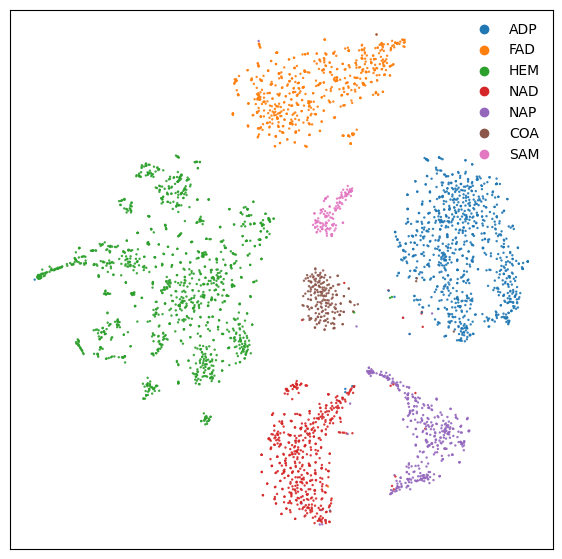

In [7]:
# Get ErePOC Repr's t-SNE result
ErePOC_tsne = tsne.fit_transform(ErePOC_repr_array.detach().numpy())
print("ErePOC t-SNE Shape: ", ErePOC_tsne.shape)

dot_size, dot_alpha, dot_linewidths = 3, 0.9, 0
plt.figure(figsize=(7,7))
plt.scatter(ErePOC_tsne[:, 0], ErePOC_tsne[:, 1], c=[colors[i] for i in pocket_labels[:]], s=dot_size, alpha=dot_alpha, linewidths=dot_linewidths)
plt.legend(custom_lines, legend_names, loc='upper right', bbox_to_anchor=(1.0, 1.0), frameon=False, fontsize=10)
plt.xticks([]); plt.yticks([])
plt.show()